In [4]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import matplotlib.pyplot as plt

tf.get_logger().setLevel(logging.ERROR)
from notebooks.load_dataset.load_dataset import (
    classes,
    x_train,
    y_train,
    x_test,
    y_test,
)

170498071/170498071 [==============================] - 5s 0us/step


In [5]:
# Представлення назв класів у вигляді словника

class_names = {

    0: classes[0],

    1: classes[1],

    2: classes[2],

    3: classes[3],

    4: classes[4],

    5: classes[5],

    6: classes[6],

    7: classes[7],

    8: classes[8],

    9: classes[9],

}

In [6]:
def preprocess_image_input(input_images):
    """
    Виконує попередню обробку вхідних зображень для подальшого використання в моделі ResNet50.

    Аргументи:
    input_images (numpy.array): Вхідні зображення у вигляді масиву.

    Повертає:
    numpy.array: Оброблені зображення.
    """
    input_images = input_images.astype("float32")
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims


def feature_extractor(inputs):
    """
    Створює екстрактор ознак на базі моделі ResNet50 без верхніх шарів.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор для екстрактора ознак.

    Повертає:
    tf.Tensor: Тензор з витягнутими ознаками.
    """

    feature_extractor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )(inputs)
    return feature_extractor

def classifier(inputs):
    """
    Створює класифікатор на основі витягнутих ознак.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор з витягнутими ознаками.

    Повертає:
    tf.Tensor: Тензор з класифікаційними виходами.
    """
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

    return x



def final_model(inputs):


    """
    Створює фінальну модель, що включає попередню обробку, екстракцію ознак та класифікацію.

    Аргументи:
    inputs (tf.Tensor): Вхідний тензор для моделі.

    Повертає:
    tf.Tensor: Тензор з класифікаційними виходами.
    """

    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)

    classification_output = classifier(resnet_feature_extractor)

    return classification_output



def define_compile_model():
    """
    Визначає та компілює кінцеву модель.

    Повертає:
    tf.keras.Model: Скомпільована модель.
    """

    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)

    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(

        optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [9]:
# Трансформуємо вхідні дані
train_X = preprocess_image_input(x_train)
valid_X = preprocess_image_input(x_test)

In [13]:
# Визначаємо модель
model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [14]:
# Тренуємо модель
history = model.fit(
    train_X,
    y_train,
    epochs=5,
    validation_split=0.2,
    batch_size=64,
)

Epoch 1/5
625/625 [==============================] - 443s 656ms/step - loss: 0.4519 - accuracy: 0.8529 - val_loss: 0.2203 - val_accuracy: 0.9240
Epoch 2/5
625/625 [==============================] - 394s 630ms/step - loss: 0.1122 - accuracy: 0.9625 - val_loss: 0.1881 - val_accuracy: 0.9366
Epoch 3/5
625/625 [==============================] - 393s 630ms/step - loss: 0.0368 - accuracy: 0.9899 - val_loss: 0.1641 - val_accuracy: 0.9470
Epoch 4/5
625/625 [==============================] - 408s 653ms/step - loss: 0.0157 - accuracy: 0.9965 - val_loss: 0.1704 - val_accuracy: 0.9488
Epoch 5/5
625/625 [==============================] - 408s 653ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.1770 - val_accuracy: 0.9513


In [ ]:
# Зберігаємо модель
model.save("resnet_best.keras")

In [15]:
# Перевіряємо на тестових даних
loss, accuracy = model.evaluate(valid_X, y_test, batch_size=64)

157/157 [==============================] - 27s 170ms/step - loss: 0.1905 - accuracy: 0.9487


In [10]:
# Завантажуємо модель
model = tf.keras.models.load_model("models/resnet_best.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

1/1 [==============================] - 2s 2s/step
 Labels:      [2 1 9 9 7 2 5 1 8 1 6 3 0 8 8]
 Predictions: [2 1 9 9 7 3 3 1 8 1 6 5 0 8 8]


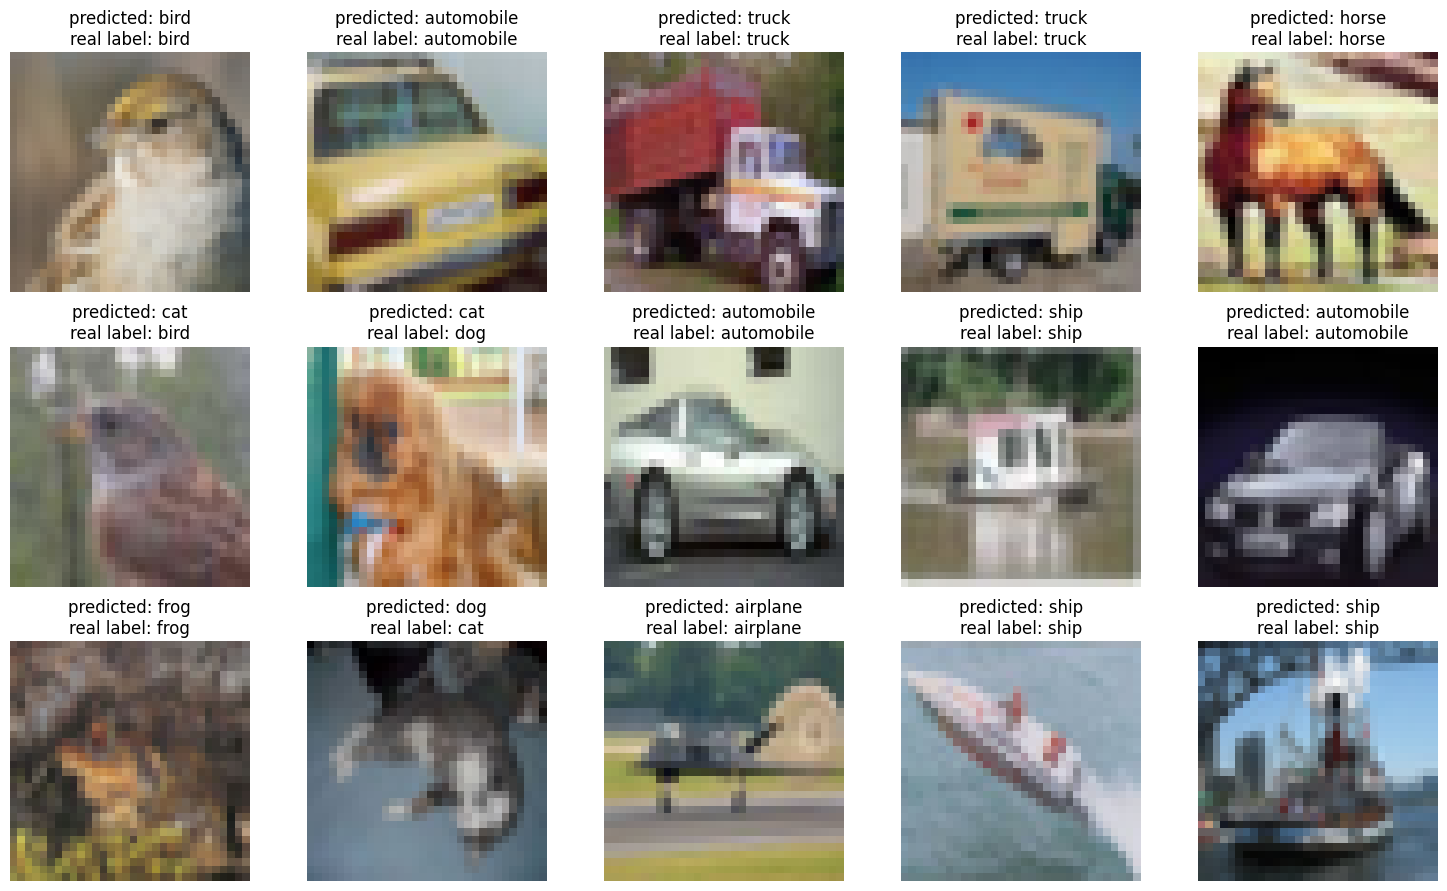

In [16]:
# Візуалізуємо результати
from results.functions import visualize_predictions, history_plot, calculate_percent_right_mob

visualize_predictions(model)

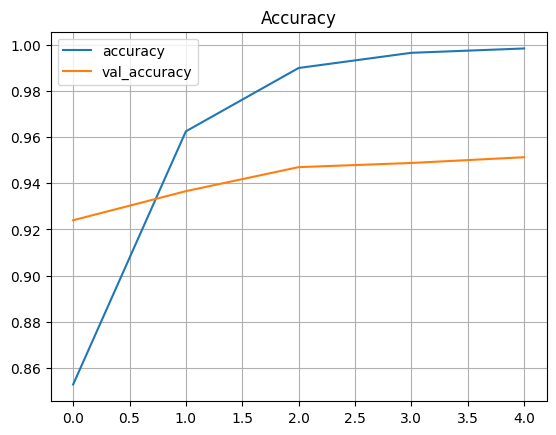

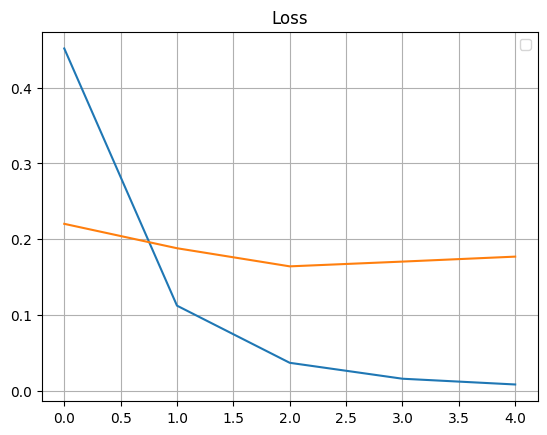

In [17]:
history_plot(history)

313/313 [==============================] - 31s 89ms/step
Клас 0 (airplane): правильно класифіковано 963 з 1000 (96.30%)
Клас 1 (automobile): правильно класифіковано 974 з 1000 (97.40%)
Клас 2 (bird): правильно класифіковано 927 з 1000 (92.70%)
Клас 3 (cat): правильно класифіковано 879 з 1000 (87.90%)
Клас 4 (deer): правильно класифіковано 963 з 1000 (96.30%)
Клас 5 (dog): правильно класифіковано 918 з 1000 (91.80%)
Клас 6 (frog): правильно класифіковано 981 з 1000 (98.10%)
Клас 7 (horse): правильно класифіковано 952 з 1000 (95.20%)
Клас 8 (ship): правильно класифіковано 978 з 1000 (97.80%)
Клас 9 (truck): правильно класифіковано 952 з 1000 (95.20%)


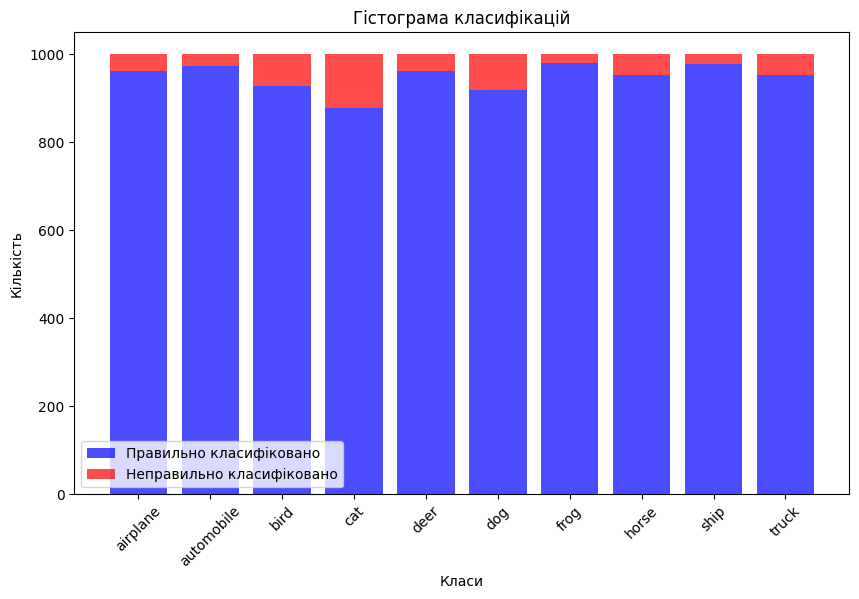

In [18]:
calculate_percent_right_mob(valid_X, y_test, model=model)